# Introduction to PHYRE

PHYRE consists of an environment, a two-dimensional world with Newtonian physics, and a set of tasks.
Each task consists of an initial scene with some geometric bodies and a goal condition that should be satisified.
An agent can introduce one or two extra objects into a scene. Once done, the agent request of sumulation of scene.
The task is considered to be **solved**, if after the simulation the goal condition is satisfied.

The image below shows three different tasks (on the left) and result of simulation with a ball introduced into the scene. Note that in the current version of the dataset all tasks have the same goal: a pair of colored object (blue, green, or purple) should touch each other.


This notebook shows how to use the ```phyre``` API to interact with the environment and tasks and how to train a simple random agent.

![PHYRE tasks](../imgs/task_example.png "PHYRE tasks and simulation example")



### Run this in colab
You can open and play with this notebook in colab. 
<a href="https://colab.research.google.com/github/facebookresearch/phyre/blob/master/examples/01_phyre_intro.ipynb" target="_parent">Open In Colab</a>

In [ ]:
# Install phyre and auxiliary packages.
# !pip install phyre matplotlib tqdm ipywidgets

In [4]:
import phyre.loader
all_tasks = phyre.loader.load_compiled_task_dict()
print(len(all_tasks))

300


In [16]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
# import torch
import phyre
from phyre.vis import WAD_COLORS

random.seed(0)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# WAD_COLORS_TORCH = torch.tensor(WAD_COLORS)

# Part 1: Introduction to PHYRE simulator


As described in the [PHYRE paper](https://arxiv.org/abs/1908.05656), the dataset consists consists of two groups of tasks referred to as **tiers**.
Currently we have two tiers: `ball` and `two_balls`. Tasks in the former tier are guaranteed to be solvable with a single ball, i.e., a goal condition could be satisfied at the end of simulation if a ball of right size is introduced at a right location. Naturally, tasks in the latter tier require two balls.

Within each tier tasks are grouped in **task templates**. Each template consists of 100 conceptually similar modifications. The image below shows some examples of tasks from different templates and from the same template.

![PHYRE tasks](../imgs/cross_within.png "PHYRE tasks and templates")


## Eval setups

We can measure two types of generalization: within template and cross template.
This could be done for both tiers resulting in four **eval setups**.
Each eval setup defines which tasks to use for training, validation and testing. One can access the list of eval setups using `phyre.MAIN_EVAL_SETUPS`.

In [9]:
eval_setups = ['ball_cross_template', 'two_balls_cross_template']
all_tasks_dict = {}
all_tiers = []
all_tasks_list = []
for eval_setup in eval_setups:
    train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, 0)
    tasks = train_tasks + dev_tasks + test_tasks
    # if True:
    #     tasks = random.sample(tasks, 50)
    action_tier = phyre.eval_setup_to_action_tier(eval_setup)
    all_tiers += [action_tier] * len(tasks)
    # simulator = phyre.initialize_simulator(tasks, action_tier)  
    all_tasks_dict[eval_setup] = {
        'eval_setup': eval_setup,
        'tasks': tasks,
        'action_tier': action_tier,
        # 'simulator': simulator,
    }
    print(action_tier)

    all_tasks_list += tasks

    print(len(all_tasks_list))
    print(len(all_tiers))
    
# Check for duplicate task IDs
unique_task_ids = set(all_tasks_list)
if len(unique_task_ids) < len(all_tasks_list):
    print(f"There are {len(all_tasks_list) - len(unique_task_ids)} duplicate task IDs.")
else:
    print("No duplicate task IDs.")


    

ball
200
200
two_balls
300
300
No duplicate task IDs.


In [7]:
template_dict = {}
for task in all_tasks_list:
    template_id, instance_id = task.split(':')
    if template_id not in template_dict:
        template_dict[template_id] = []
    template_dict[template_id].append(instance_id)

print(len(template_dict))
print(sorted(list(template_dict.keys())))
# for t in template_dict.values():
#     print(len(t))


3
['00000', '00100', '10000']


For any type of generalization we can build multiple splits intro train, dev, and test. Moreover, different splits will have different complexity. Due to that reason we recommend to use 10 folds to report results (see paper for details). Here, we will a single fold.

In [8]:
all_tasks_list.sort()
print(all_tasks_list[:20])
print(all_tasks_list[-20:])

['00000:000', '00000:001', '00000:002', '00000:003', '00000:004', '00000:005', '00000:006', '00000:007', '00000:008', '00000:009', '00000:010', '00000:011', '00000:012', '00000:013', '00000:014', '00000:015', '00000:016', '00000:017', '00000:018', '00000:019']
['10000:080', '10000:081', '10000:082', '10000:083', '10000:084', '10000:085', '10000:086', '10000:087', '10000:088', '10000:089', '10000:090', '10000:091', '10000:092', '10000:093', '10000:094', '10000:095', '10000:096', '10000:097', '10000:098', '10000:099']


With an action tier and a set of tasks, we can build a simulator using `phyre.initialize_simulator`. For simplicity, we'll use the first 50 items from the dev split.

In [12]:
simulator = phyre.initialize_simulator(['10000:080'], action_tier='ball')  

#### Initial vectorized objects

In addition to the pixelized initial scenes, one can also get access to a vectorized state of each scene object in it's initial posiition. Each task is represented as a FeaturizedObjects, which contains features represented as a 1 x (NUM_SCENE_OBJECTS + TASK_TIER_NUM_USER_INPUTS) x 14 np.ndarray. The features of the object, in order are:


  0. x in pixels of center of mass divided by SCENE_WIDTH
  1. y in pixels of center of mass divided by SCENE_HEIGHT
  2. angle of the object between 0 and 2pi divided by 2pi
  3. diameter in pixels of object divided by SCENE_WIDTH
  4. \- 8. One hot encoding of the object shape, according to order: ball, bar, jar, standing sticks
  8. \- 14. One hot encoding of object color, according to order: red, green, blue, purple, gray, black
  
As the scene is vectorized into prior to user input, the rows represent only scene objects.

#### Simulation

The action space is always a unit cube, but the dimension depends on the action tier. For the ball tier, the dimensionality of the action space is 3, corresponding to the (x,y) position of the ball and its radius r. For two ball tiers the dimension is 6.

In [13]:
print('Dimension of the action space:', simulator.action_space_dim)

Dimension of the action space: 3


We can also use the simulator to sample a fixed set of random actions from the action space using `build_discrete_action_space`. The function samples actions uniformly from the action cube skipping invalid ones. The set is guaranteed to be deterministic.

In [14]:
actions = simulator.build_discrete_action_space(max_actions=100)
print('A random action:', actions[0])

A random action: [4.17022005e-01 7.20324493e-01 1.14374817e-04]


Now that we have an action, we can use the simulator to simulate it. Let's simulate it on the first task instance in our dataset. The simulator returns a Simulation object containing, **status** of the simulation (`phyre.SimulationStatus`), intermediate observations, and information about the object states in a FeaturizedObjects object.

In [17]:
task_index = 0  # The simulator takes an index into simulator.task_ids.
action = random.choice(actions)
# Set need_images=False and need_featurized_objects=False to speed up simulation, when only statuses are needed.
# TIME = FRAMES / FPS = k / (STRIDE * FPS)
fps = 5
STRIDE = int(100 / fps) #keep  STRIDE=20
simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True, stride=STRIDE)

The first peice of information stored in the `simulation` is the status of the simulation.

In [ ]:
# Three statuses could be returned.
print('Action solves task:', phyre.SimulationStatus.SOLVED)
print('Action does not solve task:', phyre.SimulationStatus.NOT_SOLVED)
print('Action is an invalid input on task (e.g., occludes a task object):',
      phyre.SimulationStatus.INVALID_INPUT)
# May call is_* methods on the status to check the status.
print()
print('Result of taking action', action, 'on task', tasks[task_index], 'is:',
      simulation.status)
print('Does', action, 'solve task', tasks[task_index], '?', simulation.status.is_solved())
print('Is', action, 'an invalid action on task', tasks[task_index], '?',
      simulation.status.is_invalid())

In [18]:

from functools import partial
import time

import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def normalize_probabilities(p1, p2, p3):
    """Normalize the probabilities to sum to 1."""
    total = p1 + p2 + p3
    return p1 / total, p2 / total, p3 / total

p1 = 0.00 # random
p2 = 0.20 # heuristic
# p3 = 0.10 # stable solution 
p3 = 0.80 # stable solution 
ignore_sticks = True
MAX_RADIUS = 0.2
RADIUS_SCALE = 5.0

fps = 5
STRIDE = int(100 / fps) #keep  STRIDE=20
MAX_SIMULATION_STEPS=1000 # max_frames=50, max duration=10 seconds

# Normalize probabilities
p1, p2, p3 = normalize_probabilities(p1, p2, p3)

def generate_action(featurized_objects, num_balls, is_valid_action, num_sampled_actions=1, eps=0.01,):
    """
    Generate a valid action based on the specified probabilities and methods.
    
    Parameters:
    - featurized_objects: np.ndarray, the initial states of scene objects.
    - p1, p2, p3: floats, probabilities for each action generation method.
    - candidate_actions: list of actions (np.ndarray) to sample from.
    - num_balls: int, number of user balls (1 or 2).
    - is_valid_action: function, checks if the generated action is valid.
    - eps: float, a small epsilon value to ensure a gap between the object and the scene's upper bound.
    
    Returns:
    - action: np.ndarray, the generated valid action.
    """
    action_dim = 3 * num_balls
    filtered_object_id = []
    min_radius, max_radius = 1.0, 0
    for i in range(featurized_objects.shape[1]):
        if featurized_objects[0, i, 4] == 1:
            cur_radius = featurized_objects[0, i, 3]/2
            min_radius = min(min_radius, cur_radius/2)
            max_radius = max(max_radius, cur_radius*4.0)
        if ignore_sticks and featurized_objects[0, i, 5] == 1: # bar
            continue
        filtered_object_id.append(i)
    max_radius = min(max_radius, 1.0/RADIUS_SCALE)
    
    sampled_actions = []
    
    while True:
        # Choose the method based on normalized probabilities
        choice = np.random.choice(['random', 'positioning', 'candidate'], p=[p1, p2, p3])
        
        if choice == 'random':
            # Random sample from action space, adjust dimensions for one or two ball tier
            action = np.random.rand(action_dim)
            action[2] = np.random.uniform(min_radius, max_radius) * RADIUS_SCALE
        elif choice == 'positioning': 
            action = []
            for _ in range(num_balls):
                # Calculate positioning above another object with constraints
                object_idx = random.sample(filtered_object_id, k=1)[0]
                # print(object_idx)
                object_info = featurized_objects[0, object_idx]  # Including diameter for radius calculation
                radius = object_info[3] / 2
                my_radius = np.random.uniform(min_radius, max_radius)
                max_distubance = radius + my_radius
                x_disturbance = np.random.uniform(-0.8 * max_distubance, 0.8 * max_distubance)
                y_lower_bound = object_info[1] + x_disturbance * 0.9
                y_upper_bound = 1.0 - radius - eps
                my_y_pos = np.random.uniform(y_lower_bound, y_upper_bound)
                action.extend([object_info[0] + x_disturbance, my_y_pos, my_radius * RADIUS_SCALE])
            action = np.array(action)
        else:  # 'candidate'
            # Sample from the candidate action set, adjusting for one or two balls if necessary
            action_idx = np.random.randint(0, len(candidate_solutions))
            action = candidate_solutions[action_idx][:action_dim]
        
        # Check if the action is valid
        if is_valid_action(action):
            sampled_actions.append(action)
            if len(sampled_actions) == num_sampled_actions:
                return sampled_actions
            

def simulate(simulator, task_index, num_trials):
    batched_images = []
    initial_featurized_objects = simulator.initial_featurized_objects[task_index]
    valid_action_check = lambda x: simulator._action_mapper.action_to_user_input(x)[1]
    solve_cnt = 0
    
    # print(initial_featurized_objects.features)
    
    
    for i in range(num_trials):
        while True:
            
            action = generate_action(
                initial_featurized_objects.features,
                num_balls=int(simulator.action_space_dim/3),
                is_valid_action=valid_action_check,
                num_sampled_actions=1,
            )[0]
            
            
            # Set need_images=False and need_featurized_objects=False to speed up simulation, when only statuses are needed.
            # TIME = FRAMES / FPS = k / (STRIDE * FPS)
            # print(f'{action}')
            simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True
                                                   , stride=STRIDE,  max_simulation_steps=MAX_SIMULATION_STEPS)
            
            if not simulation.status.is_invalid(): 
                # print(action)

                batched_images.append(simulation.images)
                if simulation.status.is_solved():
                    # print('sovled. Frames is ', len(simulation.images))
                    solve_cnt += 1
                break
            
    print(f'Success rate of sampled actions to solve the task: {solve_cnt/num_trials*100:.1f} ({num_trials} trials)')
    
    return batched_images



def sample_and_simulate(simulator, task_index, num_trials, task_name, candidate_solutions, max_loop_per_action=100):
    """
    combine generate_action and simulate to avoid repreated invalid action from generate_action
    p1, p2, p3: floats, probabilities for each action generation method.
    """
    batched_images = []
    batched_actions = []
    batched_final_objects = []
    initial_featurized_objects = simulator.initial_featurized_objects[task_index]
    featurized_objects = initial_featurized_objects.features
    is_valid_action = lambda x: simulator._action_mapper.action_to_user_input(x)[1]
    num_balls = int(simulator.action_space_dim/3)
    solve_cnt = 0
    eps = 0.05
    
    if candidate_solutions is not None:
        new_p1, new_p2, new_p3 = normalize_probabilities(p1, p2, p3)
        new_p3 = min(len(candidate_solutions) / num_trials, new_p3)
        new_p1 = (1 - new_p3) / (new_p1 + new_p2) * new_p1
        new_p2 = (1 - new_p3) / (new_p1 + new_p2) * new_p2
        # print(new_p1, new_p2, new_p3)
    else:
        new_p1, new_p2, new_p3 = normalize_probabilities(p1, p2, 0)
    
    filtered_object_id = []
    min_radius, max_radius = 1.0, 0
    for i in range(featurized_objects.shape[1]):
        if featurized_objects[0, i, 4] == 1:
            cur_radius = featurized_objects[0, i, 3]/2
            min_radius = min(min_radius, cur_radius/2)
            max_radius = max(max_radius, cur_radius*4.0)
        if ignore_sticks and featurized_objects[0, i, 5] == 1 and np.abs(featurized_objects[0, i, 2]) < 0.05: # ignore horizon bar
            continue
        filtered_object_id.append(i)
        
    min_radius = max(min_radius, 0.1/RADIUS_SCALE)
    max_radius = min(max_radius, 1.0/RADIUS_SCALE)
    if len(filtered_object_id) == 0:
        filtered_object_id = list(range(featurized_objects.shape[1]))
    if min_radius == 1.0 or max_radius == 0:
        min_radius = 0.1/RADIUS_SCALE
        max_radius = 1.0/RADIUS_SCALE
        
    random_action_space = None
    
    # print(initial_featurized_objects.features)
    
    for i in range(num_trials):
        loop_cnt = 0
        while True:
            # if loop_cnt > 0 and loop_cnt % 100 == 0: print(loop_cnt)
            # if loop_cnt > 1000: return None, None
            # Set need_images=False and need_featurized_objects=False to speed up simulation, when only statuses are needed.
            # TIME = FRAMES / FPS = k / (STRIDE * FPS)
            # Choose the method based on normalized probabilities
            choice = np.random.choice(['random', 'positioning', 'candidate'], p=[new_p1, new_p2, new_p3], )
            if loop_cnt < max_loop_per_action:
                # heuristic rules
                if choice == 'random':
                    # Random sample from action space, adjust dimensions for one or two ball tier
                    action = np.random.rand(simulator.action_space_dim)
                    action[2] = np.random.uniform(min_radius, max_radius) * RADIUS_SCALE
                    if simulator.action_space_dim == 6:
                        action[5] = np.random.uniform(min_radius, max_radius) * RADIUS_SCALE
                elif choice == 'positioning': 
                    action = []
                    for _ in range(num_balls):
                        # Calculate positioning above another object with constraints
                        object_idx = random.sample(filtered_object_id, k=1)[0]
                        # print(object_idx)
                        object_info = featurized_objects[0, object_idx]  # Including diameter for radius calculation
                        radius = object_info[3] / 2
                        my_radius = np.random.uniform(min_radius, max_radius)
                        max_distubance = radius + my_radius
                        x_disturbance = np.random.uniform(-0.8 * max_distubance, 0.8 * max_distubance)
                        if np.random.rand() < 0.5:
                            # higher than target object
                            y_lower_bound = object_info[1] + x_disturbance * 0.9
                            y_upper_bound = 1.0 - radius - eps
                        else:
                            # lower than target object
                            y_lower_bound = radius + eps 
                            y_upper_bound = object_info[1] - x_disturbance * 0.9
                        
                        my_y_pos = np.random.uniform(y_lower_bound, y_upper_bound)
                        action.extend([object_info[0] + x_disturbance, my_y_pos, my_radius * RADIUS_SCALE])
                    action = np.array(action)
                else:  # 'candidate'
                    action_idx = np.random.randint(0, len(candidate_solutions))
                    action = candidate_solutions[action_idx]
                    # print(action[2], min_radius * RADIUS_SCALE)
                    action[2] = max(action[2], min_radius * RADIUS_SCALE)
                if simulator.action_space_dim == 6:
                    action[5] = max(action[5], min_radius * RADIUS_SCALE)
            else:
                # random sample valid actions
                print(f'Task {task_name} trial {i} has sampled {loop_cnt} action, yet still has not collected one valid action.') 
                if random_action_space is None:
                    random_action_space = simulator.build_discrete_action_space(max_actions=2*num_trials)       
                action = random.choice(random_action_space)
                action[2] = np.random.uniform(min_radius, max_radius) * RADIUS_SCALE
                if simulator.action_space_dim == 6:
                    action[5] = np.random.uniform(min_radius, max_radius) * RADIUS_SCALE
                choice = 'valid_random'
            
            # Check if the action is valid
            if is_valid_action(action):
                # Set need_images=False and need_featurized_objects=False to speed up simulation, when only statuses are needed.
                # TIME = FRAMES / FPS = k / (STRIDE * FPS)
                # print(f'{action}')
                simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True
                                                    , stride=STRIDE,  max_simulation_steps=MAX_SIMULATION_STEPS)
                
                if not simulation.status.is_invalid(): 
                    print(task_name, choice, action)
                    
                    batched_images.append(simulation.images)
                    batched_actions.append(action)
                    batched_final_objects.append(simulation.featurized_objects.features[-1])
                    if simulation.status.is_solved():
                        solve_cnt += 1
                    break
            
            # invalid action or invalid status
            loop_cnt += 1

            
    # print(f'Success rate of sampled actions to solve the task: {solve_cnt/num_trials*100:.1f} ({num_trials} trials)')
    
    # log for diversity analysis
    batched_actions = np.stack(batched_actions, 0)
    batched_final_objects = np.stack(batched_final_objects, 0)
    # print(batched_actions.shape, batched_final_objects.shape)
    states = {
        'initial_objects': featurized_objects,
        'actions': batched_actions,
        'final_objects_list': batched_final_objects,
    }
    
    return batched_images, states



def analyze_diversity(task_name, states=None, ignore_sticks=True):
    actions = states['actions']
    # Convert the numpy arrays to pandas DataFrames
    df_actions = pd.DataFrame(actions, columns=[f'action {i+1}' for i in range(actions.shape[1])])


    # Create subplots
    fig_actions = px.parallel_coordinates(df_actions,
                                      labels={'Action 1': 'Action 1', 
                                              'Action 2': 'Action 2', 
                                              'Action 3': 'Action 3'},
                                      color_continuous_scale=px.colors.diverging.Tealrose)
    fig_actions.update_layout(title_text=f'{task_name} actions')
    # For Actions Plot - Adjusting range for each dimension
    for dimension in fig_actions.data[0]['dimensions']:
        dimension['range'] = [0, 1]
    fig_actions.write_image(f"vis/{task_name}_actions.png")
    # fig_actions.show()
    
    if 'final_objects_list' in states:
        # initial_state = states['initial_objects']
        states = states['final_objects_list']
        if ignore_sticks:
            object_indices = (states[0, :, 5] == 0) & ((states[0, :, 4] == 0) | (states[0, :, -1] == 0))
            states = states[:, object_indices]
        states = states[:, :, :3].mean(-1) # compress x, y, angle to a scalar
        df_states = pd.DataFrame(states, columns=[f'object {i+1}' for i in range(states.shape[1])])
        fig_states = px.parallel_coordinates(df_states, 
                                     labels={f'State {i}': f'State {i}' for i in range(1, states.shape[1] + 1)},
                                     color_continuous_scale=px.colors.diverging.Tealrose)
        fig_states.update_layout(title_text=f'{task_name} states')
        # For States Plot - Adjusting range for each dimension
        for dimension in fig_states.data[0]['dimensions']:
            dimension['range'] = [0, 1]
        fig_states.write_image(f"vis/{task_name}_states.png")
        # fig_states.show()   


ModuleNotFoundError: No module named 'plotly'

In [6]:
tier = 'ball'
cache = phyre.get_default_100k_cache(tier)


In [41]:
success_actions_dict = {}
for task_id, tier in zip(all_tasks_list, all_tiers):
    if tier != 'ball': 
        success_actions_dict[task_id] = None
        continue
    # print('Randomly selected task:', task_id)
    statuses = cache.load_simulation_states(task_id)
    success_actions = cache.action_array[statuses == phyre.SimulationStatus.SOLVED]
    success_actions_dict[task_id] = success_actions
    # if success_actions.shape[0] < 10:
    #     print(task_id)
    # print(success_actions.shape)
    # analyze_diversity(task_id, {'actions': success_actions})
    
success_actions_counts = np.array([x.shape[0] for x in success_actions_dict.values() if x is not None])
# print(success_actions_counts.min(), success_actions_counts.max(), success_actions_counts.mean())

00000:000
00000:000
00001:000
00001:000
00002:007
00002:007
00003:000
00003:000
00004:063
00004:063
00005:006
00005:006
00006:003
00006:003
00007:008
00007:008
00008:029
00008:029
00009:013
00009:013
00010:025
00010:025
00011:004
00011:004
00012:002
00012:002
00013:011
00013:011
00014:006
00014:006
00015:014
00015:014
00016:010
00016:010
00017:002
00017:002
00018:007
00018:007
00019:013
00019:013
00020:000
00020:000
00021:002
00021:002
00022:004
00022:004
00023:008
00023:008
00024:006
00024:006


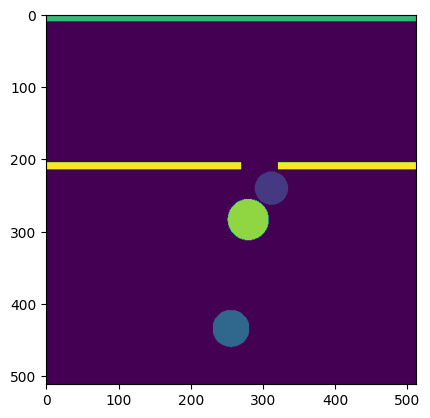

In [17]:
# vis all templates
tasks = sorted([f'{template}:{instances[0]}' for template, instances in template_dict.items()])[:25]
# print(tasks)


for i, task_name in enumerate(tasks):
    # print(task_name)
    simulator =  phyre.initialize_simulator([task_name], 'ball')
    batched_imgs, states = sample_and_simulate(simulator, 0, 1, task_name, success_actions_dict[task_name])
    print(task_name)
    plt.imshow(batched_imgs[0][0])
    for j in range(1):
        fpath = f'vis/{task_name}_t{j+1}.mp4'
        phyre.vis.save_mp4(batched_imgs[j], fps, fpath)
    
    # phyre.vis.save_observation_series_to_gif_with_space(batched_imgs,fpath)



In [49]:
from tqdm import tqdm
# vis all instances in a template
template = '00023'
tasks = sorted([f'{template}:{instance}' for instance in template_dict[template]])
print(tasks)

batched_videos = []
for i, task_name in  tqdm(enumerate(tasks)):
    # print(task_name)
    simulator =  phyre.initialize_simulator([task_name], 'ball')
    batched_imgs, states = sample_and_simulate(simulator, 0, 1, task_name, success_actions_dict[task_name])
    batched_videos.append(batched_imgs[0])



['00023:008', '00023:017', '00023:031', '00023:064', '00023:111', '00023:112', '00023:134', '00023:153', '00023:202', '00023:223', '00023:233', '00023:240', '00023:241', '00023:245', '00023:261', '00023:269', '00023:310', '00023:316', '00023:320', '00023:377', '00023:385', '00023:402', '00023:428', '00023:438', '00023:441', '00023:470', '00023:471', '00023:490', '00023:493', '00023:506', '00023:507', '00023:513', '00023:522', '00023:523', '00023:534', '00023:535', '00023:538', '00023:543', '00023:566', '00023:584', '00023:614', '00023:625', '00023:636', '00023:644', '00023:655', '00023:666', '00023:680', '00023:689', '00023:704', '00023:728', '00023:736', '00023:740', '00023:745', '00023:751', '00023:754', '00023:757', '00023:767', '00023:771', '00023:778', '00023:797', '00023:800', '00023:801', '00023:812', '00023:817', '00023:818', '00023:819', '00023:820', '00023:821', '00023:829', '00023:839', '00023:848', '00023:850', '00023:857', '00023:859', '00023:873', '00023:875', '00023:878'

1it [00:01,  1.81s/it]

00023:008 candidate [0.38901913 0.7778012  0.5632764 ]


2it [00:03,  1.74s/it]

00023:017 candidate [0.40026534 0.8227047  0.74613243]


3it [00:05,  1.80s/it]

00023:031 positioning [0.91836856 0.76646062 0.25555444]


4it [00:07,  1.91s/it]

00023:064 positioning [0.25123    0.78772907 0.52215558]


5it [00:09,  1.95s/it]

00023:111 positioning [0.70179038 0.20417323 0.42393133]


6it [00:11,  1.94s/it]

00023:112 candidate [0.22923195 0.7031352  0.8193327 ]


7it [00:13,  1.94s/it]

00023:134 candidate [0.30511308 0.65025043 0.9182987 ]


8it [00:14,  1.81s/it]

00023:153 candidate [0.3756044 0.7020086 0.865477 ]


9it [00:16,  1.88s/it]

00023:202 candidate [0.3495429  0.76838666 0.79133564]


10it [00:18,  1.89s/it]

00023:223 candidate [0.41942084 0.8404545  0.9313939 ]


11it [00:20,  1.90s/it]

00023:233 candidate [0.49038863 0.86968446 0.91695625]


12it [00:22,  1.89s/it]

00023:240 candidate [0.40159157 0.6910663  0.5820799 ]


13it [00:24,  1.88s/it]

00023:241 candidate [0.34724447 0.48988333 0.9748197 ]


14it [00:26,  2.04s/it]

00023:245 candidate [0.3865978  0.87784374 0.7159416 ]


15it [00:28,  1.98s/it]

00023:261 candidate [0.2642852  0.7272157  0.83728576]


16it [00:30,  1.93s/it]

00023:269 candidate [0.3314645  0.83742714 0.5334453 ]


17it [00:32,  1.88s/it]

00023:310 candidate [0.37261236 0.6343075  0.8023289 ]


18it [00:34,  1.93s/it]

00023:316 candidate [0.3201439  0.7244477  0.88512415]


19it [00:36,  1.89s/it]

00023:320 candidate [0.38539857 0.66997737 0.5834373 ]


20it [00:37,  1.87s/it]

00023:377 candidate [0.30969846 0.9335184  0.5272242 ]


21it [00:40,  2.05s/it]

00023:385 candidate [0.35526052 0.531867   0.9807499 ]


22it [00:42,  1.94s/it]

00023:402 candidate [0.34208903 0.4773649  0.9970231 ]


23it [00:44,  2.02s/it]

00023:428 candidate [0.26983762 0.7152293  0.95710653]


24it [00:46,  1.97s/it]

00023:438 candidate [0.34199035 0.7817078  0.6367916 ]


25it [00:48,  1.93s/it]

00023:441 candidate [0.23567012 0.72693133 0.96630734]


26it [00:49,  1.91s/it]

00023:470 candidate [0.25079164 0.65038675 0.8932627 ]


27it [00:51,  1.88s/it]

00023:471 candidate [0.2924971  0.61856985 0.8429222 ]


28it [00:53,  1.86s/it]

00023:490 candidate [0.21666656 0.78626966 0.74751323]


In [48]:

print(len(batched_videos))
print(batched_videos[0].shape)
for j in tqdm(range(len(batched_videos)//10+1)):
    fpath = f'vis/{template}_t{j*10}-{(j+1)*10}.gif'
    phyre.vis.save_observation_series_to_gif_with_space(batched_videos[j*10:(j+1)*10], fpath)

    # phyre.vis.save_observation_series_to_gif_with_space(batched_imgs,fpath)


5
(50, 512, 512)


100%|██████████| 1/1 [00:05<00:00,  5.88s/it]


In [ ]:
num_demo_tasks = 30
num_trials = 3
for eval_setup in all_tasks_dict:
    task_setup = all_tasks_dict[eval_setup]
    action_tier = task_setup['action_tier']
    if action_tier != 'ball': continue
    task_indices = sorted(random.sample(range(len(task_setup['tasks'])), k=num_demo_tasks))
    print(task_indices)
    for i, task_index in enumerate(task_indices):
        task_name = task_setup['tasks'][task_index]
        simulator =  phyre.initialize_simulator([task_name], action_tier)
        batched_imgs, states = sample_and_simulate(simulator, 0, num_trials, task_name, success_actions_dict[task_name])
        # batched_imgs, states = sample_and_simulate(simulator, 0, num_trials, task_name, None)
        if batched_imgs is None: continue
        # batched_imgs, states = sample_and_simulate(simulator, 0, num_trials, task_name, None)
        # analyze_diversity(task_name, states)
        # TODO: convert to RGB
        for j in range(num_trials):
            fpath = f'vis/{task_name}_t{j+1}.mp4'
            phyre.vis.save_mp4(batched_imgs[j], fps, fpath)
        
        # phyre.vis.save_observation_series_to_gif_with_space(batched_imgs,fpath)



In [6]:
num_demo_tasks = 30
num_trials = 3
for eval_setup in all_tasks_dict:
    task_setup = all_tasks_dict[eval_setup]
    action_tier = task_setup['action_tier']
    if action_tier == 'ball': continue
    task_indices = sorted(random.sample(range(len(task_setup['tasks'])), k=num_demo_tasks))
    print(task_indices)
    for i, task_index in enumerate(task_indices):
        task_name = task_setup['tasks'][task_index]
        simulator =  phyre.initialize_simulator([task_name], action_tier)
        batched_imgs, states = sample_and_simulate(simulator, 0, num_trials, task_name, success_actions_dict[task_name])
        # batched_imgs, states = sample_and_simulate(simulator, 0, num_trials, task_name, None)
        if batched_imgs is None: continue
        # batched_imgs, states = sample_and_simulate(simulator, 0, num_trials, task_name, None)
        # analyze_diversity(task_name, states)
        # TODO: convert to RGB
        for j in range(num_trials):
            fpath = f'vis/{task_name}_t{j+1}.mp4'
            phyre.vis.save_mp4(batched_imgs[j], fps, fpath)
        
        # phyre.vis.save_observation_series_to_gif_with_space(batched_imgs,fpath)



[165, 302, 388, 404, 412, 570, 572, 601, 894, 1026, 1060, 1154, 1242, 1270, 1352, 1449, 1466, 1577, 1658, 1722, 1778, 1933, 1952, 1990, 2067, 2094, 2181, 2292, 2389, 2465]
00102:065 positioning [0.62068209 0.78279532 0.72750365 0.70163359 0.17865962 0.12875222]
00102:065 positioning [0.5988884  0.1181126  0.75866521 0.73641244 0.28126965 0.63533885]
00102:065 positioning [0.44687722 0.30200998 0.24353101 0.68728124 0.23599528 0.74841089]
00107:002 positioning [0.26008781 0.12631872 0.30600928 0.48594887 0.24243643 0.41313409]
00107:002 positioning [0.43255542 0.20731431 0.22450044 0.35596579 0.73511356 0.55324256]
00107:002 positioning [0.44652371 0.84796946 0.40732128 0.41961438 0.2496851  0.74177481]
00107:088 positioning [0.5459241  0.81116682 0.64472868 0.50727793 0.21381896 0.19733991]
00107:088 positioning [0.4796306  0.21919121 0.65830806 0.27501402 0.50947102 0.7856138 ]
00107:088 positioning [0.48227917 0.77655262 0.44763502 0.43269443 0.15036681 0.90927379]
00108:014 position

In [3]:
import h5py
import numpy as np
import imageio
import tempfile
import imageio.v3 as iio # need python at least 3.9
from pathlib import Path
import time
from io import BytesIO

def read_file_to_byte_stream(file_path):
    """Read the entire content of a file into a byte stream."""
    with open(file_path, 'rb') as file:
        byte_stream = file.read()
    return byte_stream


def store_byte_stream_to_hdf5(byte_stream, hdf5_path, dataset_name):
    """Store a byte stream in an HDF5 file as a dataset."""
    data = np.frombuffer(byte_stream, dtype=np.uint8)
    
    with h5py.File(hdf5_path, 'w') as hdf:
        hdf.create_dataset(dataset_name, data=data, dtype='uint8')


def convert_frames_to_mp4_bytestream(frames, fps=5):
    """
    Convert a sequence of frames into an MP4 byte stream.

    Parameters:
    - frames: A list or array of frames (numpy arrays).
    - fps: Frames per second for the output video.

    Returns:
    - A byte stream of the MP4 video.
    """
    # Use a temporary file to store the video
    with tempfile.NamedTemporaryFile(delete=False, suffix='.mp4') as temp_file:
        temp_file_name = temp_file.name      
        imageio.mimsave(temp_file_name, frames, fps=fps)

        # Read the MP4 file content into a byte stream
        with open(temp_file_name, 'rb') as video_file:
            mp4_bytestream = video_file.read()
    stream_array = np.frombuffer(mp4_bytestream, dtype='uint8')
    return stream_array



def convert_frames_to_mp4_bytestream_wo_disk(frames, fps=5):
    """
    Convert a sequence of frames into an MP4 byte stream, entirely in-memory.
    
    Parameters:
    - frames: A list or array of frames (numpy arrays).
    - fps: Frames per second for the output video.
    
    Returns:
    - A byte stream of the MP4 video.
    """
    # Create an in-memory bytes buffer
    with BytesIO() as buffer:
        # Use imageio to write frames to the buffer as an MP4 video
        iio.imwrite(buffer, frames, extension='.mp4')
        
        # Get the byte stream from the buffer
        mp4_bytestream = buffer.getvalue()
    
    return np.frombuffer(mp4_bytestream, dtype=np.uint8)



def store_mp4_to_hdf5(mp4_path, hdf5_path):
    stream = read_file_to_byte_stream(mp4_path)
    store_byte_stream_to_hdf5(stream, hdf5_path, dataset_name='task1')
    
    
def store_batched_frames_to_hdf5(all_frames, hdf5_path):
    with h5py.File(hdf5_path, 'w') as hdf:
        video_dset =hdf.create_dataset('video_streams', 
                           shape=(len(all_frames),),
                           dtype=h5py.vlen_dtype(np.dtype('uint8')),
                           )   
        
        batch_size = 100
        for i in range(0, len(all_frames), batch_size):
            batched_frames = all_frames[i:i+batch_size]
            # speedup time bottleneck by parallelizing batch
            # start_time_step = time.time()
            batched_images = phyre.vis.batched_observations_to_frames(batched_frames)
            # batched_images = np.stack(batched_images, 0)
            # batched_images = WAD_COLORS[batched_images]
            # print(f"Time for obs2frames", time.time() - start_time_step, "seconds")
            
            for j, images in enumerate(batched_images):
                start_time_step = time.time()
                # writing to disk is faster than in-memory operation
                stream = convert_frames_to_mp4_bytestream(images) # time bottleneck
                # stream = convert_frames_to_mp4_bytestream_wo_disk(images) # time bottleneck
                print(f"Time for frames2bytestream", time.time() - start_time_step, "seconds")
                
                trial_id = i + j
                video_dset[trial_id] = stream

    
    return
        
    
def decode_hdf5_to_frames(hdf5_path, trial_index):
    """Decode video frames from a byte stream stored in an HDF5 file by first writing to a temporary file."""
        
    hdf = h5py.File(hdf5_path, 'r')
        
    byte_stream = hdf['video_streams'][trial_index]
    byte_obj = byte_stream.tobytes()
    # Use a temporary file to write the byte stream
    with tempfile.NamedTemporaryFile(delete=False, suffix='.mp4') as temp_file:
        temp_file_name = temp_file.name
        temp_file.write(byte_obj)
    
    # Now read the video from the temporary file
    with imageio.get_reader(temp_file_name, format='mp4') as reader:
        frames = [frame for frame in reader]
        fps = reader.get_meta_data()['fps']
    
    imageio.mimsave('deocded_v1.mp4', frames, fps=5)
    
    return np.array(frames), fps
    
def decode_hdf5_to_frames_wo_disk(hdf5_path, trial_index, format_hint='.mp4'):
    """Decode video frames from a byte stream stored in an HDF5 file directly in memory."""
    hdf = h5py.File(hdf5_path, 'r')

    byte_stream = hdf['video_streams'][trial_index]
    byte_obj = byte_stream.tobytes()
    # Decode frames directly from byte stream
    frames = iio.imread(byte_obj, index=None, extension=format_hint)
    imageio.mimsave('deocded_v2.mp4', frames, fps=5)
    action = hdf['action_streams'][trial_index]
    return frames, action

    
# store_frames_to_hdf5(batched_imgs[-1], fps, 'videos.hdf5')
# start_time = time.time()
# frames, _ = decode_hdf5_to_frames('../phyre_data_1000_v2/00001:005.hdf5', 90)
# print("decode_hdf5_to_frames: Finished in {:.2f} seconds".format(time.time() - start_time))

# start_time = time.time()
frames, action = decode_hdf5_to_frames_wo_disk('../phyre_data_1000_v3/00001:006.hdf5', 1000)
print(action)
# print("decode_hdf5_to_frames_wo_disk: Finished in {:.2f} seconds".format(time.time() - start_time))

# print(frames.shape, frames2.shape)
# frames == frames

frames2 = frames
# print(frames2.shape, frames2.dtype)

# it seems imageio in python3.9 is 2x faster than python3.6
# start_time = time.time()
# s1 = convert_frames_to_mp4_bytestream(frames2, fps=5)
# print("Finished in {:.2f} seconds".format(time.time() - start_time))

# start_time = time.time()
# s2 = convert_frames_to_mp4_bytestream_wo_disk(frames2, fps=5)
# print("Finished in {:.2f} seconds".format(time.time() - start_time))


IndexError: Index (1000) out of range for (0-999)

In [ ]:
import imageio
import imageio_ffmpeg

def gif_to_mp4(gif_path, output_path, fps=10):
    """
    Convert a GIF to an MP4 video using imageio.

    Parameters:
    - gif_path: Path to the input GIF file.
    - output_path: Path where the output MP4 file will be saved.
    - fps: Frames per second for the output video.
    """
    # Read GIF
    reader = imageio.get_reader(gif_path)
    
    # Get GIF metadata
    meta_data = reader.get_meta_data()
    
    # Define MP4 writer with desired fps
    writer = imageio.get_writer(output_path, fps=fps, codec='libx264', quality=7)

    # Iterate over GIF frames and add them to the MP4 writer
    for frame in reader:
        writer.append_data(frame)
    
    # Close writer and reader to free up resources
    writer.close()
    reader.close()

# Example usage
gif_path = 'vis/00120:099.gif'  # Replace with your GIF file path
output_path = 'vis/00120:099.mp4'  # Replace with your desired output MP4 file path
gif_to_mp4(gif_path, output_path, fps=5)




In [ ]:

def generate_videos_hdf5(tasks, action_tier, num_trials=100, data_dir='./'):
    # Start measuring time for step 1
    start_time_step1 = time.time()
    
    # Step 1: initialize simulator
    simulator = phyre.initialize_simulator(tasks, action_tier)
    # End measuring time for step 1 and print duration
    print("Time for Step 1 (initialize simulator):", time.time() - start_time_step1, "seconds")
    
    for task_index, task_name in enumerate(tasks):
        # Start measuring time for step 2
        start_time_step2 = time.time()
        
        # Step 2: simulate K trials
        batched_imgs = simulate(simulator, task_index, num_trials)
        # End measuring time for step 2 and print duration
        print(f"Time for Step 2 (simulate {num_trials} trials) for task", task_name, ":", time.time() - start_time_step2, "seconds")
        
        # Start measuring time for step 3
        start_time_step3 = time.time()
        
        # Step 3: save all trials' videos
        hdf5_path = Path(data_dir) / f'{task_name}.hdf5'
        store_batched_frames_to_hdf5(batched_imgs, hdf5_path)
        # End measuring time for step 3 and print duration
        print("Time for Step 3 (save all trials' videos) for task", task_name, ":", time.time() - start_time_step3, "seconds")
        
# eval_setup = 'ball_cross_template'
# train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, 0)
# action_tier = phyre.eval_setup_to_action_tier(eval_setup)
# tasks = train_tasks[:1]
# print(tasks, action_tier)
# generate_videos_hdf5(tasks, action_tier, num_trials=100)